## Test script for using ParameterizedDNNClassifier with SKL GridSearchCV

Keras is a library for quickly creating deep neural network (DNN) models out of standard layer types, activation functions, and other components without hand-crafting Theano or other low level code.  Keras has the additional advantage that its models can be run with Theano and TensorFlow backends without modification (usually, unless you're writing your own Keras extensions).  

Since one of the most common tasks I do with ML tools is supervised multiclass classification, I wanted an easy way to include a DNN for such classifiers whenever I'm screening models in scikit-learn.  ParameterizedDNNClassifier takes some simple parameters and the generates an appropriate multilayer DNN in Keras, with one or more fully-connected hidden layers (with specifiable activation function, defaulting to ReLU), and configurable input and output layers.  Future additions will make the optimizer and other aspects parameterized as well.  

ParameterizedDNNClassifier subclasses BaseEstimator and ClassifierMixin from scikit-learn, and provides appropriate score and predict functions which allow it to act like any other SKL estimator.  With one exception (getting training history from the underlying Keras object), you can use ParameterizedDNNClassifier in a Pipeline or in GridSearchCV, etc.  

The following test harness does a simple grid search cross validation over a synthetic classification data set with 10K data points and 10 classes.  


In [1]:
import random
import numpy as np 
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import pprint as pp

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn_mmadsen import ParameterizedDNNClassifier

%matplotlib inline

Using TensorFlow backend.


/Users/mark/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
## Seaborn confusion matrix heatmap
def confusion_heatmap(y_test, y_pred, labels):
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                     xticklabels=labels, yticklabels=labels)

In [3]:
###### Replication #######

#random.seed(7112)

In [4]:
df_x = pd.read_csv("../testdata/classification-10k-10classes-x.csv.gz")
df_y = pd.read_csv("../testdata/classification-10k-10classes-y.csv.gz")

In [5]:
############ prepare data ###########

# specify the correct data types because we're probably using the GPU
X = df_x.astype(np.float32)
y = df_y.astype(np.int32)

# one-hot encode the class label since the output layer of the DNN will have multiple units, 
# each corresponding to a class
y = pd.concat([y, pd.get_dummies(y['0']).rename(columns=lambda x: 'col_' + str(x))], axis=1)
y.drop('0', axis=1, inplace=True	)

# get pure numpy arrays
X = X.values
y = y.values

### create a train/test split ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

x_train_rows = X_train.shape[0]
x_train_cols = X_train.shape[1]
x_test_rows = X_test.shape[0]
x_test_cols = X_test.shape[1]
y_test_cols = y_test.shape[1]

# make sure the data arrays are the correct shape, or Theano will never let you hear the end of it...
X_train = X_train.reshape(x_train_rows, x_train_cols)
X_test = X_test.reshape(x_test_rows, x_test_cols)

print "Prepared data sets"
print "Train:"
print "X_train: ", X_train.shape
print "y_train: ", y_train.shape
print "\nTest:"
print "X_test: ",X_test.shape
print "y_test: ",y_test.shape 

Prepared data sets
Train:
X_train:  (8000, 20)
y_train:  (8000, 10)

Test:
X_test:  (2000, 20)
y_test:  (2000, 10)


In [6]:
params = {
	'clf__dropout_fraction': [0.9, 0.5],
	'clf__sgd_lr': [0.01, 0.1],
}

est = ParameterizedDNNClassifier(input_dimension=20,
        output_dimension=10,
		num_dense_hidden=2,
		epochs=2,
		hidden_sizes=[1000,2000,1000],
        verbose=0)

grid_search = GridSearchCV(est, params, n_jobs = 1, verbose = 1)
grid_search.fit(X_train, y_train)

# This is Keras-specific code.  The fitted model stores the history of training 
# and validation accuracy so we can examine over or underfitting.  It is also 
# useful for retrieving the actual number of training epochs in the case that
# we have early stopping activated.

history = grid_search.best_estimator_.get_history()
actual_epoch_count = len(history['acc'])


Fitting 3 folds for each of 4 candidates, totalling 12 fits
2666/2666 [==============================] - 1s     


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.5min finished


In [7]:
print "============= Best Estimator from GridSearchCV =============="

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters:")
best_params = grid_search.best_estimator_.get_params()
for param in sorted(best_params.keys()):
    print("param: %s: %r" % (param, best_params[param]))

============= Best Estimator from GridSearchCV ==============
Best score: 0.183
Best parameters:
param: batch_size: 500
param: decay: 1e-06
param: dense_activation: 'relu'
param: dropout_fraction: 0.5
param: epochs: 2
param: hidden_sizes: [1000, 2000, 1000]
param: input_dimension: 20
param: momentum: 0.9
param: num_dense_hidden: 2
param: output_activation: 'softmax'
param: output_dimension: 10
param: sgd_lr: 0.01
param: verbose: 0


In [8]:
print "============== Evaluation on Holdout Test Set ============="

predictions = grid_search.predict(X_test)
actuals = np.argmax(y_test, axis=1)

print "accuracy on test: %s" % accuracy_score(actuals, predictions)

print(classification_report(actuals, predictions))

============== Evaluation on Holdout Test Set =============
2000/2000 [==============================] - 1s     
accuracy on test: 0.1925
             precision    recall  f1-score   support

          0       0.11      0.09      0.10       202
          1       0.17      0.14      0.16       196
          2       0.15      0.34      0.21       181
          3       0.12      0.29      0.17       192
          4       0.18      0.06      0.09       214
          5       0.11      0.03      0.05       222
          6       0.29      0.20      0.24       216
          7       0.36      0.48      0.41       198
          8       0.23      0.23      0.23       184
          9       0.22      0.12      0.15       195

avg / total       0.20      0.19      0.18      2000



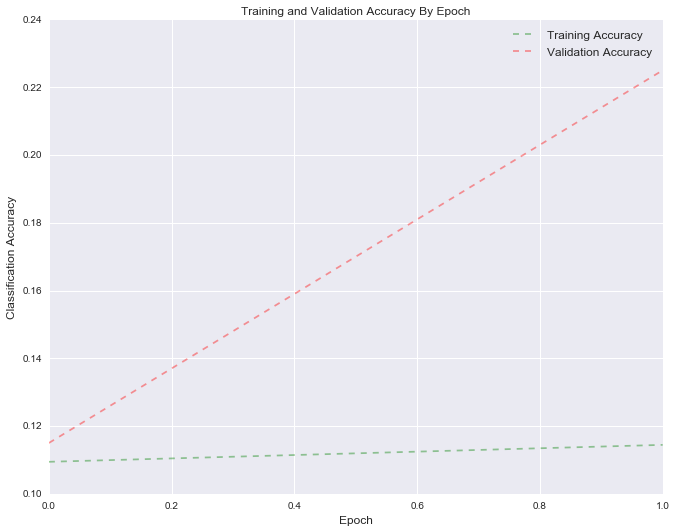

In [9]:
# build a graph of the training/validation accuracy versus training epoch
# to look for overfitting

train_acc_hist = history['acc']
val_acc_hist = history['val_acc']
epoch_list = range(0, actual_epoch_count)

dat = { 'train_acc': train_acc_hist, 'val_acc': val_acc_hist }
hist_df = pd.DataFrame(data=dat, index=epoch_list)

plt.figure(figsize=(11,8.5), dpi=300)

plt.plot(hist_df.index, hist_df['train_acc'], color='green', linestyle='dashed', marker='+',
     markerfacecolor='black', markersize=7, label="Training Accuracy", alpha=0.4)
plt.plot(hist_df.index, hist_df['val_acc'], color='red', linestyle='dashed', marker='x',
     markerfacecolor='black', markersize=7, label="Validation Accuracy", alpha=0.4)
plt.legend(fontsize='large')

plt.xlabel('Epoch', fontsize='large')
plt.ylabel('Classification Accuracy', fontsize='large')
plt.title('Training and Validation Accuracy By Epoch', fontsize='large')
plt.show()

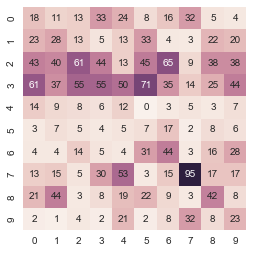

In [10]:
labels = range(0, y_test_cols)
confusion_heatmap(actuals, predictions, labels)